# Running PVAnalytics QA Routines on Power Data

Import all of the necessary packages for running QA.

In [1]:
import pandas as pd
import pvlib
import glob
import timezonefinder
from statistics import mode
import numpy as np
from matplotlib import pyplot as plt
import rdtools
import pvanalytics
from pvanalytics.quality import data_shifts as ds
from pvanalytics.quality import gaps
from pvanalytics.quality.outliers import zscore
from pvanalytics.features.daytime import power_or_irradiance
from pvanalytics.system import is_tracking_envelope, infer_orientation_fit_pvwatts
import pva_time_shifts as tsh

## Power Data

The code below can be used to run a variation of the PV Fleets (https://www.nrel.gov/pv/fleet-performance-data-initiative.html) QA routine on a measured power stream.

First, define time series CSV, and associated system latitude-longitude coordinates. Latitude-longitude coordinates will be used to model solar output at the specified location using pvlib functionality.

In [2]:
file_path = "./data/50_ac_power_2_full_DST.csv"
latitude = 39.7406
longitude = -105.1775
timezone = "GMT"
# Sign up for an NSRDB API key here: https://developer.nrel.gov/signup/
nsrdb_api_key = '4z5fRAXbGB3qldVVd3c6WH5CuhtY5mhgC2DyD952' #'YOUR_API_KEY'
nsrdb_user_email = "kirsten.perry@nrel.gov"

# Read in the file as as pandas series
time_series = pd.read_csv(file_path, parse_dates=True, index_col=0).squeeze()

# Remove any duplicate index values (this is just a failsafe in case there are!)
time_series = time_series.groupby(time_series.index).first()

Get the associated data sampling frequency of the time series.

In [3]:
# Show the time series just to check it's timezone-aware. This is important for all future analysis, as many
# PVAnalytics functions require tz-aware data.

print(time_series)

# Get the time series frequency
freq_minutes = int((mode(abs(np.diff(time_series.index)))).total_seconds() / 60)
data_freq = str(freq_minutes) + "T"

measured_on
2011-04-15 00:00:00-07:00    0.02260
2011-04-15 00:01:00-07:00   -0.04520
2011-04-15 00:02:00-07:00    0.13540
2011-04-15 00:03:00-07:00    0.24830
2011-04-15 00:04:00-07:00   -0.63210
                              ...   
2013-12-31 23:55:00-07:00    0.18041
2013-12-31 23:56:00-07:00   -0.40591
2013-12-31 23:57:00-07:00   -0.76673
2013-12-31 23:58:00-07:00   -0.58632
2013-12-31 23:59:00-07:00   -0.90204
Name: ac_power_2, Length: 1428480, dtype: float64


## Visualize Original Time Series

Visualize the starting time series as reference.

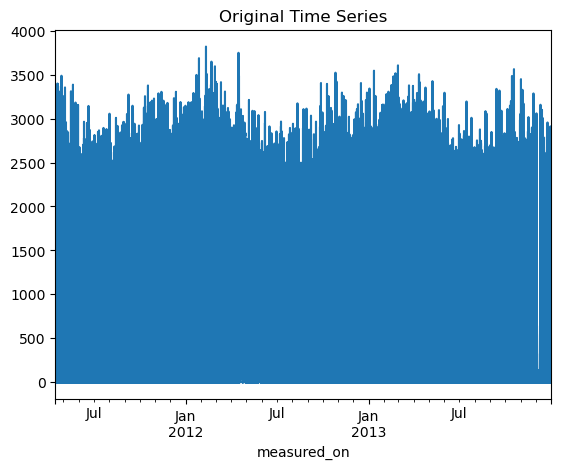

In [4]:
time_series.plot(title="Original Time Series")
plt.show()
plt.close()

## Run Basic Data Checks: Stale, Abnormal, and Negative Data

Basic data checks include removing the following:
1) Flatlined/stale data periods (https://pvanalytics.readthedocs.io/en/stable/generated/gallery/gaps/stale-data.html#sphx-glr-generated-gallery-gaps-stale-data-py)

2) Negative data 

3) "Abnormal" data periods, which are defined as less than 10% of the daily time series mean

4) Outliers, which are defined as more than one 4 standard deviations away from the mean (https://pvanalytics.readthedocs.io/en/stable/generated/gallery/outliers/zscore-outlier-detection.html#sphx-glr-generated-gallery-outliers-zscore-outlier-detection-py)

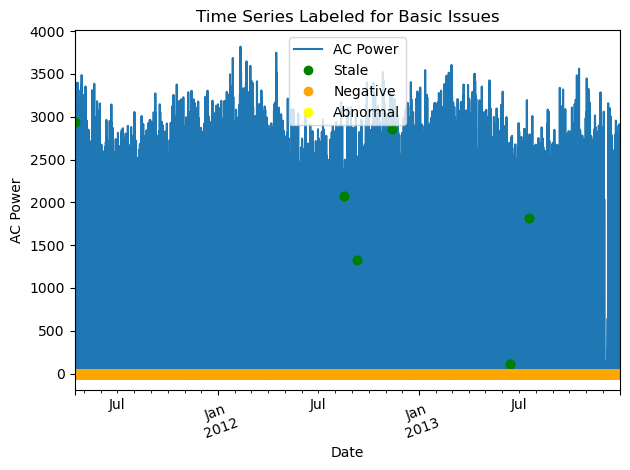

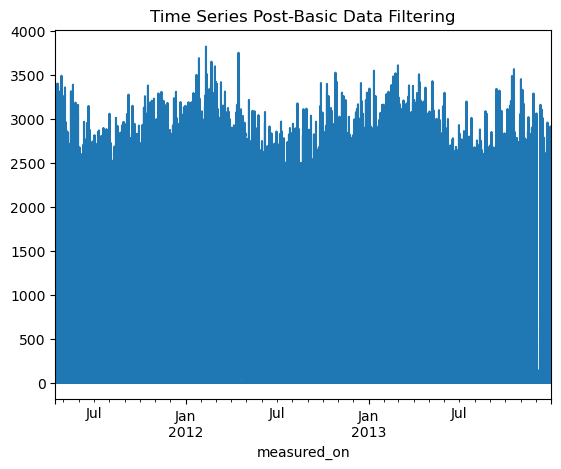

In [5]:
# 1) REMOVE STALE DATA (that isn't during nighttime periods)
# Day/night mask
daytime_mask = power_or_irradiance(time_series)
# Stale data mask
stale_data_mask = gaps.stale_values_round(time_series,
                                          window=3,
                                          decimals=2)
stale_data_mask.loc[(stale_data_mask==True) &
                    (daytime_mask == False)] = False

# 2) REMOVE NEGATIVE DATA
negative_mask = (time_series < 0)

# FIND ABNORMAL PERIODS
daily_min = time_series.resample('D').min()
series_min = 0.1 * time_series.mean()
erroneous_mask = (daily_min < series_min)
erroneous_mask = erroneous_mask.reindex(index=time_series.index,
                                        method='ffill',
                                        fill_value=False)

# FIND OUTLIERS (Z-SCORE FILTER)
zscore_outlier_mask = zscore(time_series, zmax=4,
                             nan_policy='omit')

# Get the percentage of data flagged for each issue, so it can later be logged
pct_stale = round((len(time_series[stale_data_mask].dropna())/len(time_series.dropna())*100), 1)
pct_negative = round((len(time_series[negative_mask].dropna())/len(time_series.dropna())*100), 1)
pct_erroneous = round((len(time_series[~erroneous_mask].dropna())/len(time_series.dropna())*100), 1)
pct_outlier = round((len(time_series[zscore_outlier_mask].dropna())/len(time_series.dropna())*100), 1)

# Visualize all of the time series issues (stale, abnormal, outlier, etc)
time_series.plot()
labels = ["AC Power"]
if any(stale_data_mask):
    time_series.loc[stale_data_mask].plot(ls='', marker='o', color = "green")
    labels.append("Stale")
if any(negative_mask):
    time_series.loc[negative_mask].plot(ls='', marker='o', color = "orange")
    labels.append("Negative")
if any(~erroneous_mask):
    time_series.loc[~erroneous_mask].plot(ls='', marker='o', color = "yellow")
    labels.append("Abnormal")
if any(zscore_outlier_mask):
    time_series.loc[zscore_outlier_mask].plot(ls='', marker='o', color = "purple")
    labels.append("Outlier")
plt.legend(labels=labels)
plt.title("Time Series Labeled for Basic Issues")
plt.xticks(rotation=20)
plt.xlabel("Date")
plt.ylabel("AC Power")
plt.tight_layout()
plt.show()
plt.close()

# Filter the time series, taking out all of the issues
time_series = time_series[~stale_data_mask]
time_series = time_series[~negative_mask]
time_series = time_series[erroneous_mask]
time_series = time_series[~zscore_outlier_mask]
time_series = time_series.asfreq(data_freq)

# Visualize the time series post-filtering
time_series.plot(title = "Time Series Post-Basic Data Filtering")
plt.show()
plt.close()

## Filter by Completeness Score
Filter the time series by a daily "completeness" score (https://pvanalytics.readthedocs.io/en/stable/generated/gallery/gaps/data-completeness.html#sphx-glr-generated-gallery-gaps-data-completeness-py).This filtering scheme requires at least 25% of data to be present for each day for it to be included. We further require that there be at least 10 consecutive days meeting this 25% threshold for the day to be included (see https://pvanalytics.readthedocs.io/en/stable/generated/pvanalytics.quality.gaps.trim_incomplete.html#pvanalytics.quality.gaps.trim_incomplete for more info).

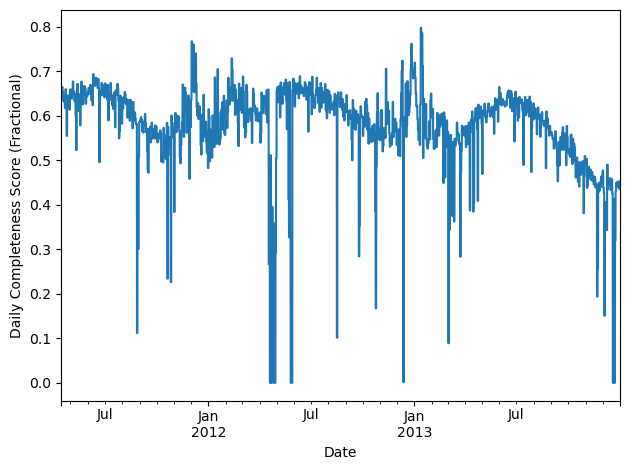

C:\ProgramData\Anaconda3\envs\pvfleets_qa_analysis\lib\site-packages\pvanalytics\quality\gaps.py:413: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  mask.loc[start.date():end.date()] = True


In [6]:
# Visualize daily data completeness
data_completeness_score = gaps.completeness_score(time_series)

# Visualize data completeness score as a time series.
data_completeness_score.plot()
plt.xlabel("Date")
plt.ylabel("Daily Completeness Score (Fractional)")
plt.tight_layout()
plt.show()

# Trim the series based on daily completeness score
trim_series = pvanalytics.quality.gaps.trim_incomplete(time_series,
                                                       minimum_completeness=.25,
                                                       freq=data_freq)
first_valid_date, last_valid_date = pvanalytics.quality.gaps.start_stop_dates(trim_series)
time_series = time_series[first_valid_date.tz_convert(time_series.index.tz):last_valid_date.tz_convert(time_series.index.tz)]
time_series = time_series.asfreq(data_freq)

## Check for time shifts in the time series

The "midday" point between sunrise and sunset is calculated for each day in the time series, and compared to the modelled "midday" point using the current time zone. Modeled midday is subtracted from measured midday, and the difference is scrutinized for time shifts using changepoint detection.

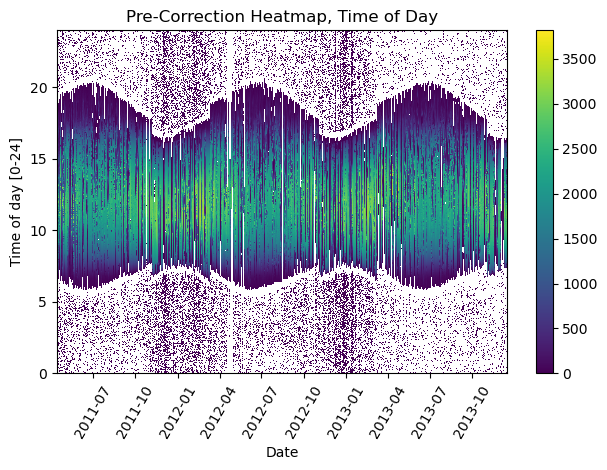

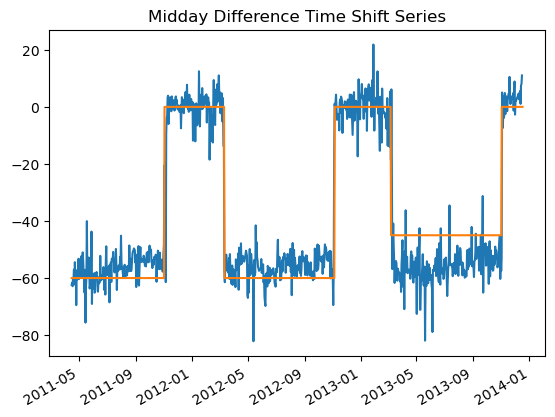

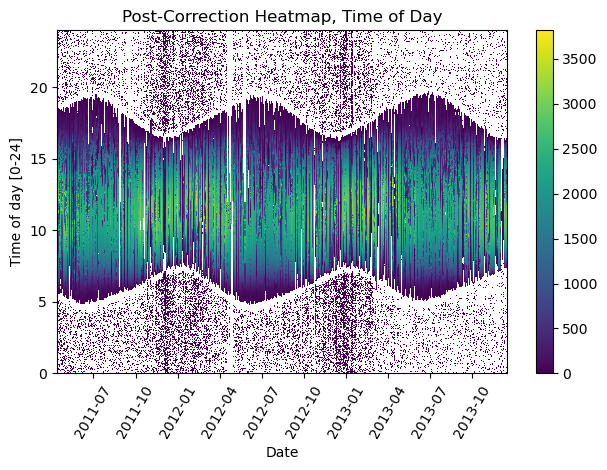

In [7]:
# Plot the heatmap of the AC power time series
plt.figure()
# Get time of day from the associated datetime column
time_of_day = pd.Series(time_series.index.hour +
                        time_series.index.minute/60,
                        index=time_series.index)
# Pivot the dataframe
dataframe = pd.DataFrame(pd.concat([time_series, time_of_day], axis=1))    
dataframe.columns = ["values", 'time_of_day']
dataframe = dataframe.dropna()
dataframe_pivoted = dataframe.pivot_table(index='time_of_day',
                                          columns=dataframe.index.date,
                                          values="values")
plt.pcolormesh(dataframe_pivoted.columns,
               dataframe_pivoted.index,
               dataframe_pivoted,
               shading='auto')
plt.ylabel('Time of day [0-24]')
plt.xlabel('Date')
plt.xticks(rotation=60)
plt.title('Pre-Correction Heatmap, Time of Day')
plt.colorbar()
plt.tight_layout()
plt.show()
plt.close()

# CHECK FOR TIME SHIFTS 
midday_diff_series, time_shift_series = tsh.detect_time_shifts(
            time_series, latitude, longitude, freq_minutes)

# Generate boolean for detected time shifts
if any(time_shift_series != 0):
    time_shifts_detected = True
else:
    time_shifts_detected = False

# Build a list of dictionaries for time shifts
time_shift_series.index = pd.to_datetime(time_shift_series.index).tz_localize(time_series.index.tz)
changepoints = (time_shift_series != time_shift_series.shift(1))
changepoints = changepoints[changepoints].index
changepoint_amts = pd.Series(time_shift_series.loc[changepoints])
time_shift_list = list()
for idx in range(len(changepoint_amts)):
    try:
        time_shift_list.append({"datetime_start": str(changepoint_amts.index[idx]),
                                "datetime_end": str(changepoint_amts.index[idx + 1]),
                                "time_shift": changepoint_amts[idx]})
    except:
        time_shift_list.append({"datetime_start": str(changepoint_amts.index[idx]),
                                "datetime_end": str(time_shift_series.index.max()),
                                "time_shift": changepoint_amts[idx]})

# Correct any time shifts in the time series
new_index = pd.Series(time_series.index, index=time_series.index)
for i in time_shift_list:
    new_index[(time_series.index >= pd.to_datetime(i['datetime_start'])) &
              (time_series.index < pd.to_datetime(i['datetime_end']))] = \
            time_series.index + pd.Timedelta(minutes=i['time_shift'])
time_series.index = new_index
# Remove duplicated indices and sort the time series (just in case)
time_series = time_series[~time_series.index.duplicated(keep='first')].sort_index()

# Plot the difference between measured and modeled midday, as well as the CPD-estimated time shift series.
midday_diff_series.plot()
time_shift_series.plot()
plt.title("Midday Difference Time Shift Series")
plt.show()
plt.close()

# Plot the heatmap of the AC power time series
plt.figure()
# Get time of day from the associated datetime column
time_of_day = pd.Series(time_series.index.hour +
                        time_series.index.minute/60,
                        index=time_series.index)
# Pivot the dataframe
dataframe = pd.DataFrame(pd.concat([time_series, time_of_day], axis=1))    
dataframe.columns = ["values", 'time_of_day']
dataframe = dataframe.dropna()
dataframe_pivoted = dataframe.pivot_table(index='time_of_day',
                                          columns=dataframe.index.date,
                                          values="values")
plt.pcolormesh(dataframe_pivoted.columns,
               dataframe_pivoted.index,
               dataframe_pivoted,
               shading='auto')
plt.ylabel('Time of day [0-24]')
plt.xlabel('Date')
plt.xticks(rotation=60)
plt.title('Post-Correction Heatmap, Time of Day')
plt.colorbar()
plt.tight_layout()
plt.show()
plt.close()

## Determine Data Shifts

Examine the daily time series for abrupt capacity shifts, and determine the longest continuous part of the series free of data shifts. Once again, changepoint detection is used to determine shift dates.

Shift Found??
False


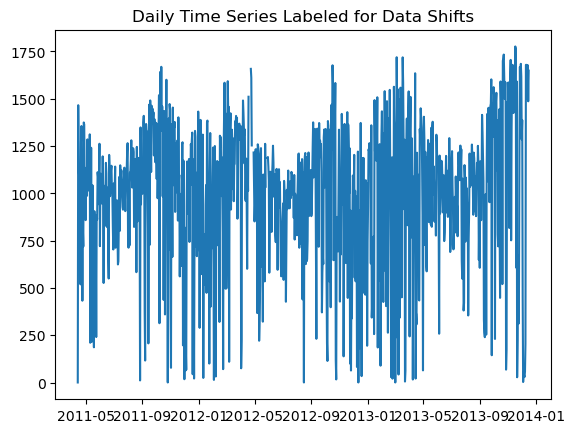

In [8]:
# Resample the time series to daily mean
time_series_daily = time_series.resample('D').mean()
data_shift_start_date, data_shift_end_date = \
            ds.get_longest_shift_segment_dates(time_series_daily)
data_shift_period_length = (data_shift_end_date - data_shift_start_date).days

# Get the number of shift dates
data_shift_mask = pvanalytics.quality.data_shifts.detect_data_shifts(time_series_daily)
# Get the shift dates
shift_dates = list(time_series_daily[data_shift_mask].index)
if len(shift_dates) > 0:            
    shift_found = True
else:
    shift_found = False

# Visualize the time shifts for the daily time series
print("Shift Found??")
print(shift_found)
edges = [time_series_daily.index[0]] + shift_dates + [time_series_daily.index[-1]]
fig, ax = plt.subplots()
for (st, ed) in zip(edges[:-1], edges[1:]):
    ax.plot(time_series_daily.loc[st:ed])
plt.title("Daily Time Series Labeled for Data Shifts")
plt.show()
plt.close()

In [9]:
# Filter the time series to only include the longest shift-free period
time_series = time_series[(time_series.index >= data_shift_start_date.tz_convert(time_series.index.tz)) &
                          (time_series.index <= data_shift_end_date.tz_convert(time_series.index.tz))]

time_series = time_series.asfreq(data_freq)

## Identify and Remove Clipped Periods

Use logic-based and ML-based clipping functions to identify clipped periods in the time series data, and plot the filtered data if applicable.

In [10]:
# REMOVE CLIPPING PERIODS
clipping_mask = ~rdtools.filtering.logic_clip_filter(time_series)
# Get the pct clipping
clipping_mask.dropna(inplace=True)
pct_clipping = round(100*(len(clipping_mask[
    clipping_mask])/len(clipping_mask)), 4)
if pct_clipping >= 0.5:
    clipping = True
    clip_pwr = time_series[clipping_mask].median()
else:
    clipping = False
    clip_pwr = np.nan
# Plot the time series with clipping, if clipping is present
if clipping:
    time_series.plot()
    time_series.loc[clipping_mask].plot(ls='', marker='o')
    plt.legend(labels=["AC Power", "Clipping"],
               title="Clipped")
    plt.title("Time Series Labeled for Clipping")
    plt.xticks(rotation=20)
    plt.xlabel("Date")
    plt.ylabel("AC Power")
    plt.tight_layout()
    plt.show()
    plt.close()

## Identify the Mounting Configuration

Look at the daily power profile for summer and winter months, and identify if the data stream is associated with a fixed-tilt or single axis tracking system.

In [11]:
# CHECK MOUNTING CONFIGURATION
daytime_mask = power_or_irradiance(time_series)
predicted_mounting_config = is_tracking_envelope(time_series,
                                                 daytime_mask,
                                                 clipping_mask)

print("Predicted Mounting configuration:")
print(predicted_mounting_config.name)

Predicted Mounting configuration:
UNKNOWN


## Estimate Azimuth and Tilt

Estimate the azimuth and tilt of the system, based on the power series data.

In [12]:
# Pull down PSM3 data via PVLib and process it for merging with the time series
time_series = time_series.dropna()
psm3s = []
years = list(time_series.index.year.drop_duplicates())
years = [int(x) for x in years if x <= 2020]
for year in years:
    # Pull from API and save locally
    psm3, _ = pvlib.iotools.get_psm3(latitude, longitude,
                                    nsrdb_api_key,
                                    nsrdb_user_email, year,
                                    attributes=['air_temperature',
                                                'ghi', 'clearsky_ghi',
                                                'clearsky_dni', 'clearsky_dhi'],
                                     map_variables=True,
                                     interval=30,
                                     leap_day=True,
                                     timeout=60)
    psm3s.append(psm3)
if len(psm3s) > 0:
    psm3 = pd.concat(psm3s)
    psm3 = psm3.reindex(pd.date_range(psm3.index[0],
                                      psm3.index[-1],
                                      freq=data_freq)).interpolate()
    psm3.index = psm3.index.tz_convert(time_series.index.tz)
    psm3 = psm3.reindex(time_series.index)
    is_clear = (psm3.ghi_clear == psm3.ghi)
    is_daytime = (psm3.ghi > 0)

    # Trim based on clearsky and daytime values
    time_series_clearsky = time_series.reindex(is_daytime.index)[(is_clear) & (is_daytime)]

    # Get final PSM3 data
    psm3_clearsky = psm3.loc[time_series_clearsky.index]
    solpos_clearsky = pvlib.solarposition.get_solarposition(time_series_clearsky.index,
                                                            latitude,
                                                            longitude)

    #Estimate the azimuth and tilt using PVWatts-based method
    predicted_tilt, predicted_azimuth, r2 = infer_orientation_fit_pvwatts(time_series_clearsky,
                                                                          psm3_clearsky.ghi_clear,
                                                                          psm3_clearsky.dhi_clear,
                                                                          psm3_clearsky.dni_clear,
                                                                          solpos_clearsky.zenith,
                                                                          solpos_clearsky.azimuth,
                                                                          temperature=psm3_clearsky.temp_air,
                                                                          azimuth_min=90,
                                                                          azimuth_max=275)
    print("Predicted azimuth: " + str(predicted_azimuth))
    print("Predicted tilt: " + str(predicted_tilt))
else:
    print("PSM3 data period not available for analysis!")
    predicted_azimuth, predicted_tilt = None, None

Predicted azimuth: 166.17190336373645
Predicted tilt: 42.273336813452424


## Display the final filtered time series

Show the final time series post-processing as reference.

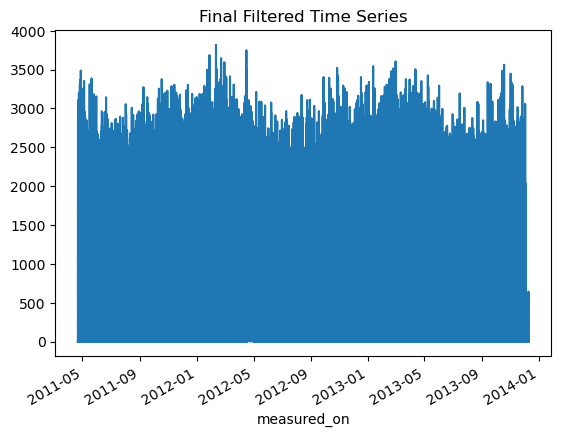

In [13]:
time_series.plot(title="Final Filtered Time Series")
plt.show()
plt.close()

## Generate QA Report

Generate a dictionary outlining all of the different issues present for the time series.

In [14]:
qa_check_dict = {"original_time_zone_offset": time_series.index.tz,
                 "pct_stale": pct_stale,
                 "pct_negative": pct_negative,
                 "pct_erroneous": pct_erroneous,
                 "pct_outlier": pct_outlier,
                 "time_shifts_detected": time_shifts_detected,
                 "time_shift_list": time_shift_list,
                 "data_shifts": shift_found,
                 "shift_dates": shift_dates,
                 "clipping": clipping,
                 "clipping_threshold": clip_pwr,
                 "pct_clipping": pct_clipping,
                 "mounting_config": predicted_mounting_config.name,
                 "predicted_azimuth": predicted_azimuth,
                 "predicted_tilt": predicted_tilt,
                 "filtered_time_series": time_series}

print("QA Results:")
print(qa_check_dict)

QA Results:
{'original_time_zone_offset': pytz.FixedOffset(-420), 'pct_stale': 0.0, 'pct_negative': 40.6, 'pct_erroneous': 0.0, 'pct_outlier': 0.0, 'time_shifts_detected': True, 'time_shift_list': [{'datetime_start': '2011-04-15 00:00:00-07:00', 'datetime_end': '2011-11-02 00:00:00-07:00', 'time_shift': -60.0}, {'datetime_start': '2011-11-02 00:00:00-07:00', 'datetime_end': '2012-03-11 00:00:00-07:00', 'time_shift': 0.0}, {'datetime_start': '2012-03-11 00:00:00-07:00', 'datetime_end': '2012-11-05 00:00:00-07:00', 'time_shift': -60.0}, {'datetime_start': '2012-11-05 00:00:00-07:00', 'datetime_end': '2013-03-07 00:00:00-07:00', 'time_shift': 0.0}, {'datetime_start': '2013-03-07 00:00:00-07:00', 'datetime_end': '2013-11-02 00:00:00-07:00', 'time_shift': -45.0}, {'datetime_start': '2013-11-02 00:00:00-07:00', 'datetime_end': '2013-12-17 00:00:00-07:00', 'time_shift': 0.0}], 'data_shifts': False, 'shift_dates': [], 'clipping': False, 'clipping_threshold': nan, 'pct_clipping': 0.0238, 'mount